# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr28.pkl", "rb") as file:
    genes_dict28 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
hs_genes = genes_dict28['human']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


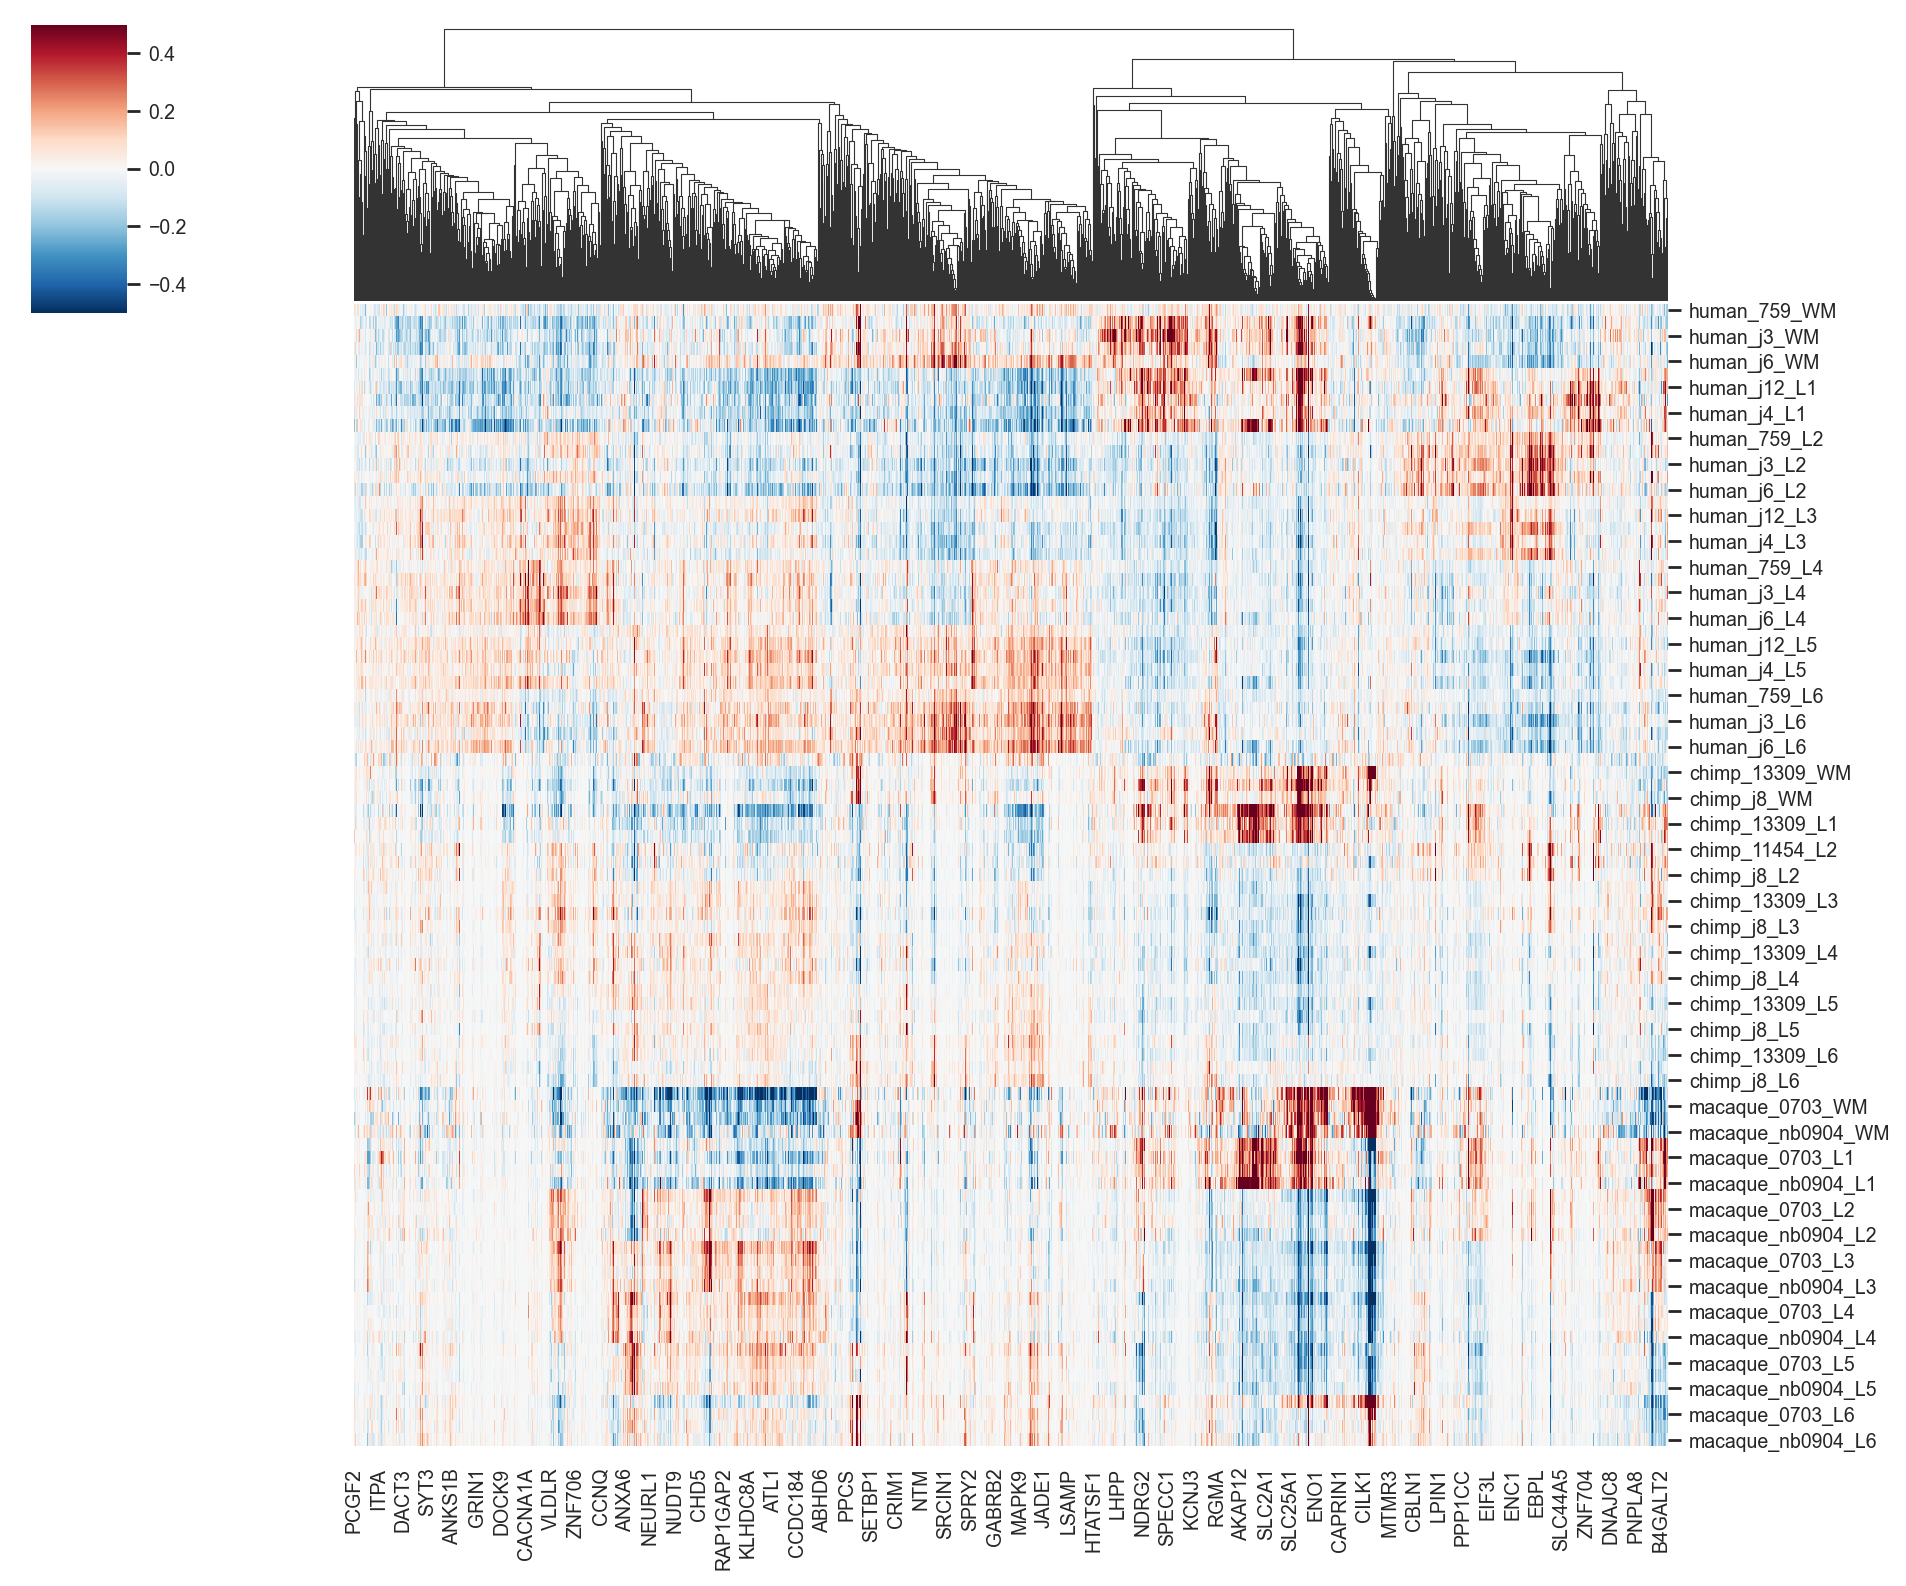

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [19]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.loc[sample_order['human']].T, metric='cosine') + 1
n_clusters = 5
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=5,
                   random_state=4)

In [20]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/human_clusters_28.csv')

<Axes: >

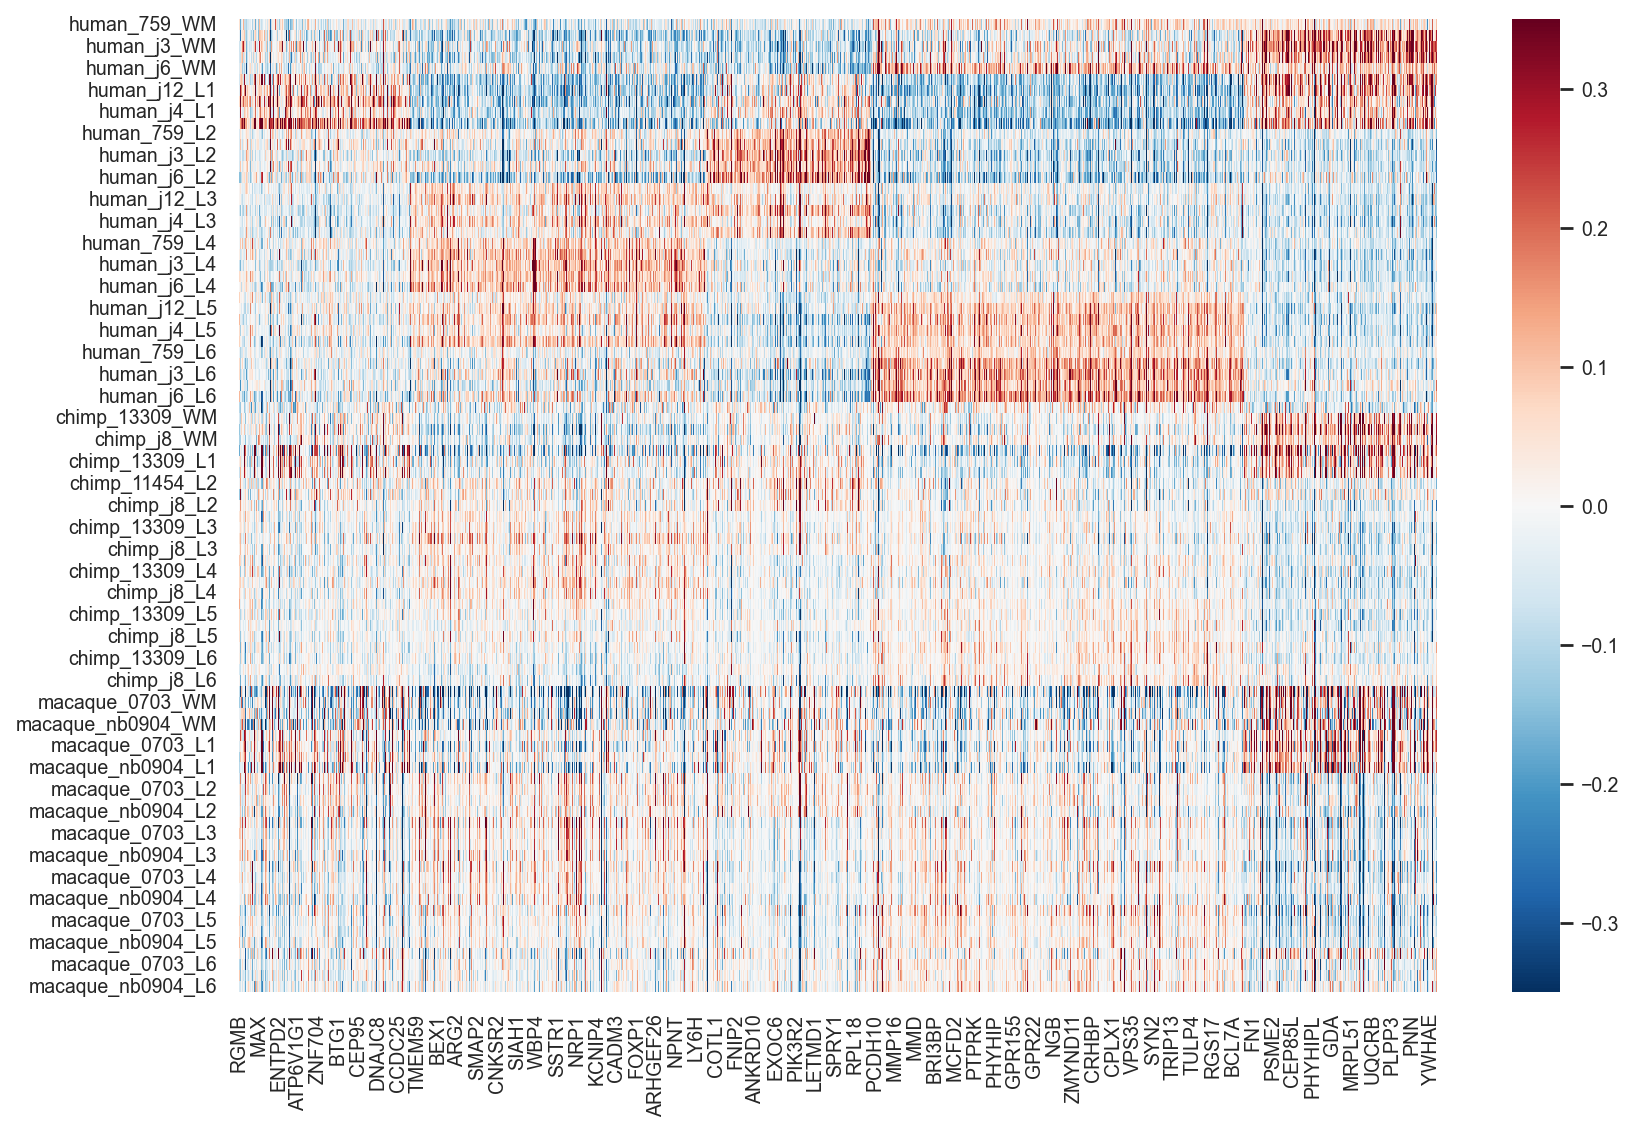

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.35, vmin=-0.35, center=0)

## Cluster profiles

In [23]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [24]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

A1BG     AADAT      AAK1  AASDHPPT     ABCA3     ABHD6  \
condition layer                                                               
chimp     L1     0.000311  0.004136 -0.005820 -0.129857  0.002673 -0.128820   
          L2    -0.025557 -0.001924 -0.014660  0.004536 -0.019373  0.081598   
          L3     0.076603  0.028048 -0.007055  0.040311 -0.005012 -0.039633   
          L4     0.062482  0.007185 -0.018464  0.054389 -0.002816  0.020756   
          L5    -0.010620 -0.009728 -0.007488  0.018721 -0.002795  0.006443   

                     ABI2       ABR    ABRACL     ACSL1  ...   ZNF385B  \
condition layer                                          ...             
chimp     L1    -0.059771  0.010527 -0.017871 -0.015967  ... -0.036294   
          L2     0.010944 -0.006620 -0.076166 -0.071008  ... -0.043503   
          L3     0.062355 -0.001679 -0.051858 -0.022306  ... -0.050027   
          L4     0.020539  0.001134  0.000519  0.019382  ...  0.000221   
          L5    -0.015000 -0.005726  0.029795  0.054718  ...  0.068736   

                  ZNF385D    ZNF593    ZNF608    ZNF638    ZNF704    ZNF706  \
condition layer                                                               
chimp     L1    -0.003534 -0.079360  0.038487  0.044235  0.003669  0.020416   
          L2    -0.006205  0.037296  0.134900  0.038163  0.000972  0.121583   
          L3    -0.009346  0.022026  0.011861 -0.037186  0.000329  0.067006   
          L4    -0.020457  0.042626 -0.057859 -0.088954  0.000982 -0.001815   
          L5     0.001033  0.025991 -0.050288 -0.032903 -0.001422 -0.035676   

                    ZNRF3    ZSWIM6       ZYX  
condition layer                                
chimp     L1     0.020308  0.004193  0.005605  
          L2    -0.019569 -0.006481 -0.003745  
          L3    -0.014304 -0.001571  0.003216  
          L4    -0.002362 -0.005166  0.003341  
          L5    -0.019414 -0.001691 -0.002624  

[5 rows x 1386 columns]

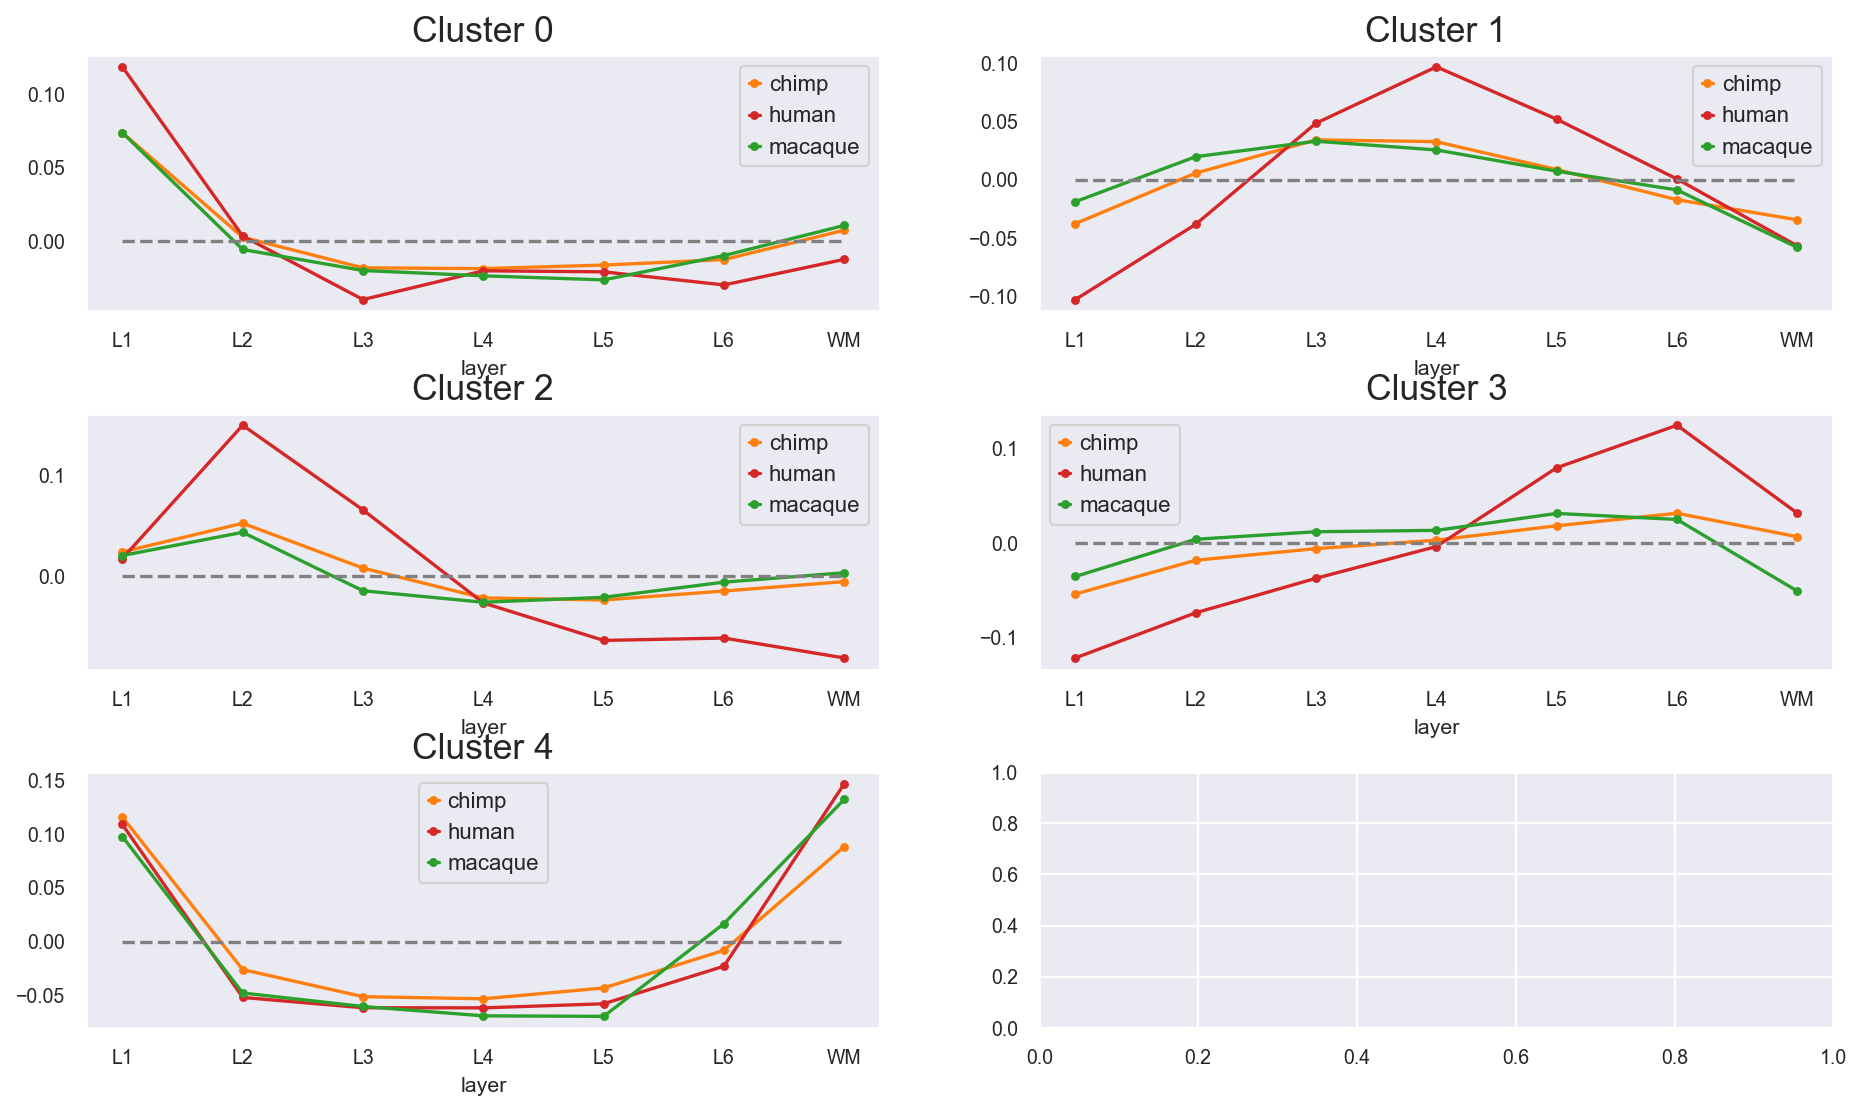

In [25]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [26]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['A1BG', 'AADAT', 'AAK1', 'ABCA3', 'ABHD6', 'ABI2', 'ABR', 'ABRACL',
       'ACSL1', 'ACSL4',
       ...
       'ZMYND11', 'ZMYND8', 'ZNF385B', 'ZNF385D', 'ZNF593', 'ZNF704', 'ZNF706',
       'ZNRF3', 'ZSWIM6', 'ZYX'],
      dtype='object', length=1193)

In [27]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0      1      2      3     4
ANOVA_labels                                 
0             20.0   71.0  126.0    3.0   0.0
1             11.0    6.0   14.0   61.0   6.0
2              3.0  131.0    0.0  263.0   6.0
3             17.0   11.0    7.0    4.0  25.0
4             46.0    7.0    1.0   11.0  39.0
5             33.0   75.0    5.0   37.0  22.0
6             33.0    2.0   11.0   10.0  76.0

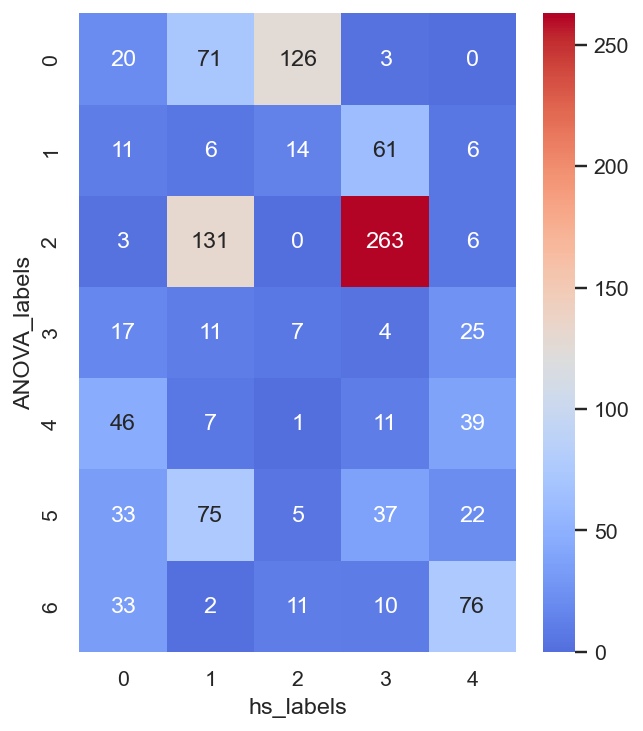

In [28]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", center=120)
plt.grid(False)

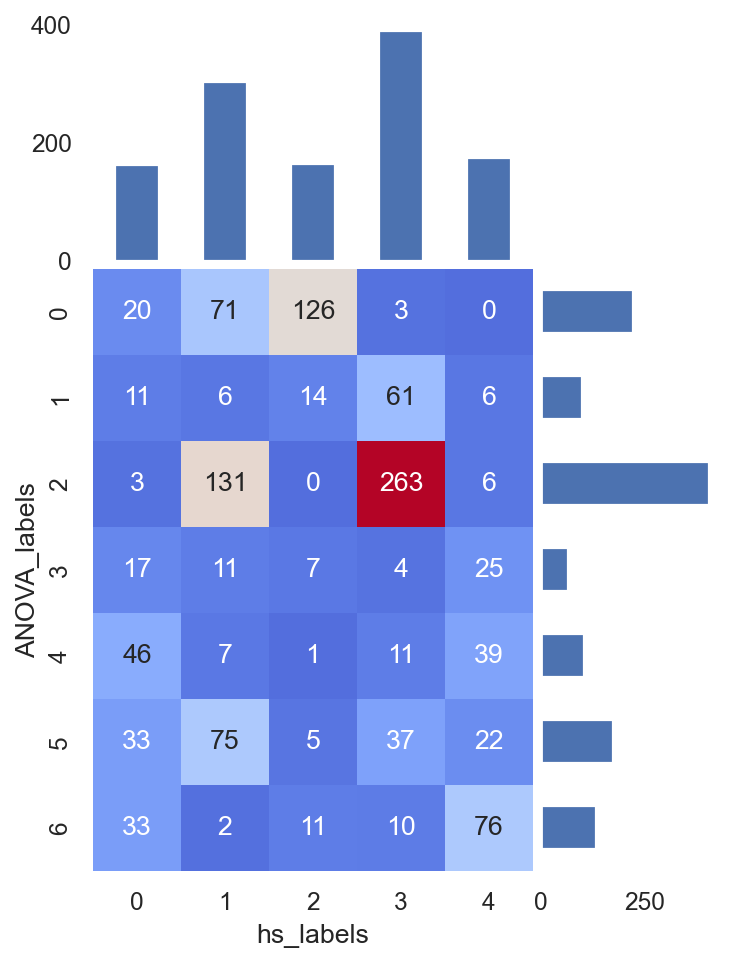

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=120, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [30]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/5 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [31]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [32]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                         
skeletal system development (GO:0001501)            1  0.000015   7.103175   
epithelial cell differentiation (GO:0030855)        2  0.000067   8.017239   
mitochondrial respirasome assembly (GO:0097250)     3  0.000095  69.292308   
extracellular matrix organization (GO:0030198)      4  0.000105   4.837169   
heart development (GO:0007507)                      5  0.000234   5.455988   

                                                 Combined score  \
Term                                                              
skeletal system development (GO:0001501)              78.792035   
epithelial cell differentiation (GO:0030855)          77.091645   
mitochondrial respirasome assembly (GO:0097250)      641.857724   
extracellular matrix organization (GO:0030198)        44.335716   
heart development (GO:0007507)                        45.604185   

                                                                                 Overlapping genes  \
Term                                                                                                 
skeletal system development (GO:0001501)         [COL1A1, RPS6KA3, AKAP13, DLX5, ZBTB16, PLS3, ...   
epithelial cell differentiation (GO:0030855)      [LGALS3, DAB2, TAGLN, MAF, ERBB4, TAGLN2, PROX1]   
mitochondrial respirasome assembly (GO:0097250)                           [COX7A2, COX7A1, HIGD2A]   
extracellular matrix organization (GO:0030198)   [COL1A1, COL18A1, COL3A1, GSN, FLRT2, SERPINH1...   
heart development (GO:0007507)                   [AKAP13, COL3A1, FLRT2, CITED2, ERBB4, ID2, ND...   

                                                 Adjusted P-value  \
Term                                                                
skeletal system development (GO:0001501)                 0.022702   
epithelial cell differentiation (GO:0030855)             0.038979   
mitochondrial respirasome assembly (GO:0097250)          0.038979   
extracellular matrix organization (GO:0030198)           0.038979   
heart development (GO:0007507)                           0.069893   

                                                 Old p-value  \
Term                                                           
skeletal system development (GO:0001501)                   0   
epithelial cell differentiation (GO:0030855)               0   
mitochondrial respirasome assembly (GO:0097250)            0   
extracellular matrix organization (GO:0030198)             0   
heart development (GO:0007507)                             0   

                                                 Old adjusted p-value  \
Term                                                                    
skeletal system development (GO:0001501)                            0   
epithelial cell differentiation (GO:0030855)                        0   
mitochondrial respirasome assembly (GO:0097250)                     0   
extracellular matrix organization (GO:0030198)                      0   
heart development (GO:0007507)                                      0   

                                                 num_overlap_genes  \
Term                                                                 
skeletal system development (GO:0001501)                         9   
epithelial cell differentiation (GO:0030855)                     7   
mitochondrial respirasome assembly (GO:0097250)                  3   
extracellular matrix organization (GO:0030198)                  10   
heart development (GO:0007507)                                   8   

                                                 neg_log10(p_adj)  \
Term                                                                
skeletal system development (GO:0001501)                 1.643938   
epithelial cell differentiation (GO:0030855)             1.409166   
mitochondrial respirasome assembly (GO:0097250)          1.409166   
extracellular matrix organization (G

In [33]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

28

In [34]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

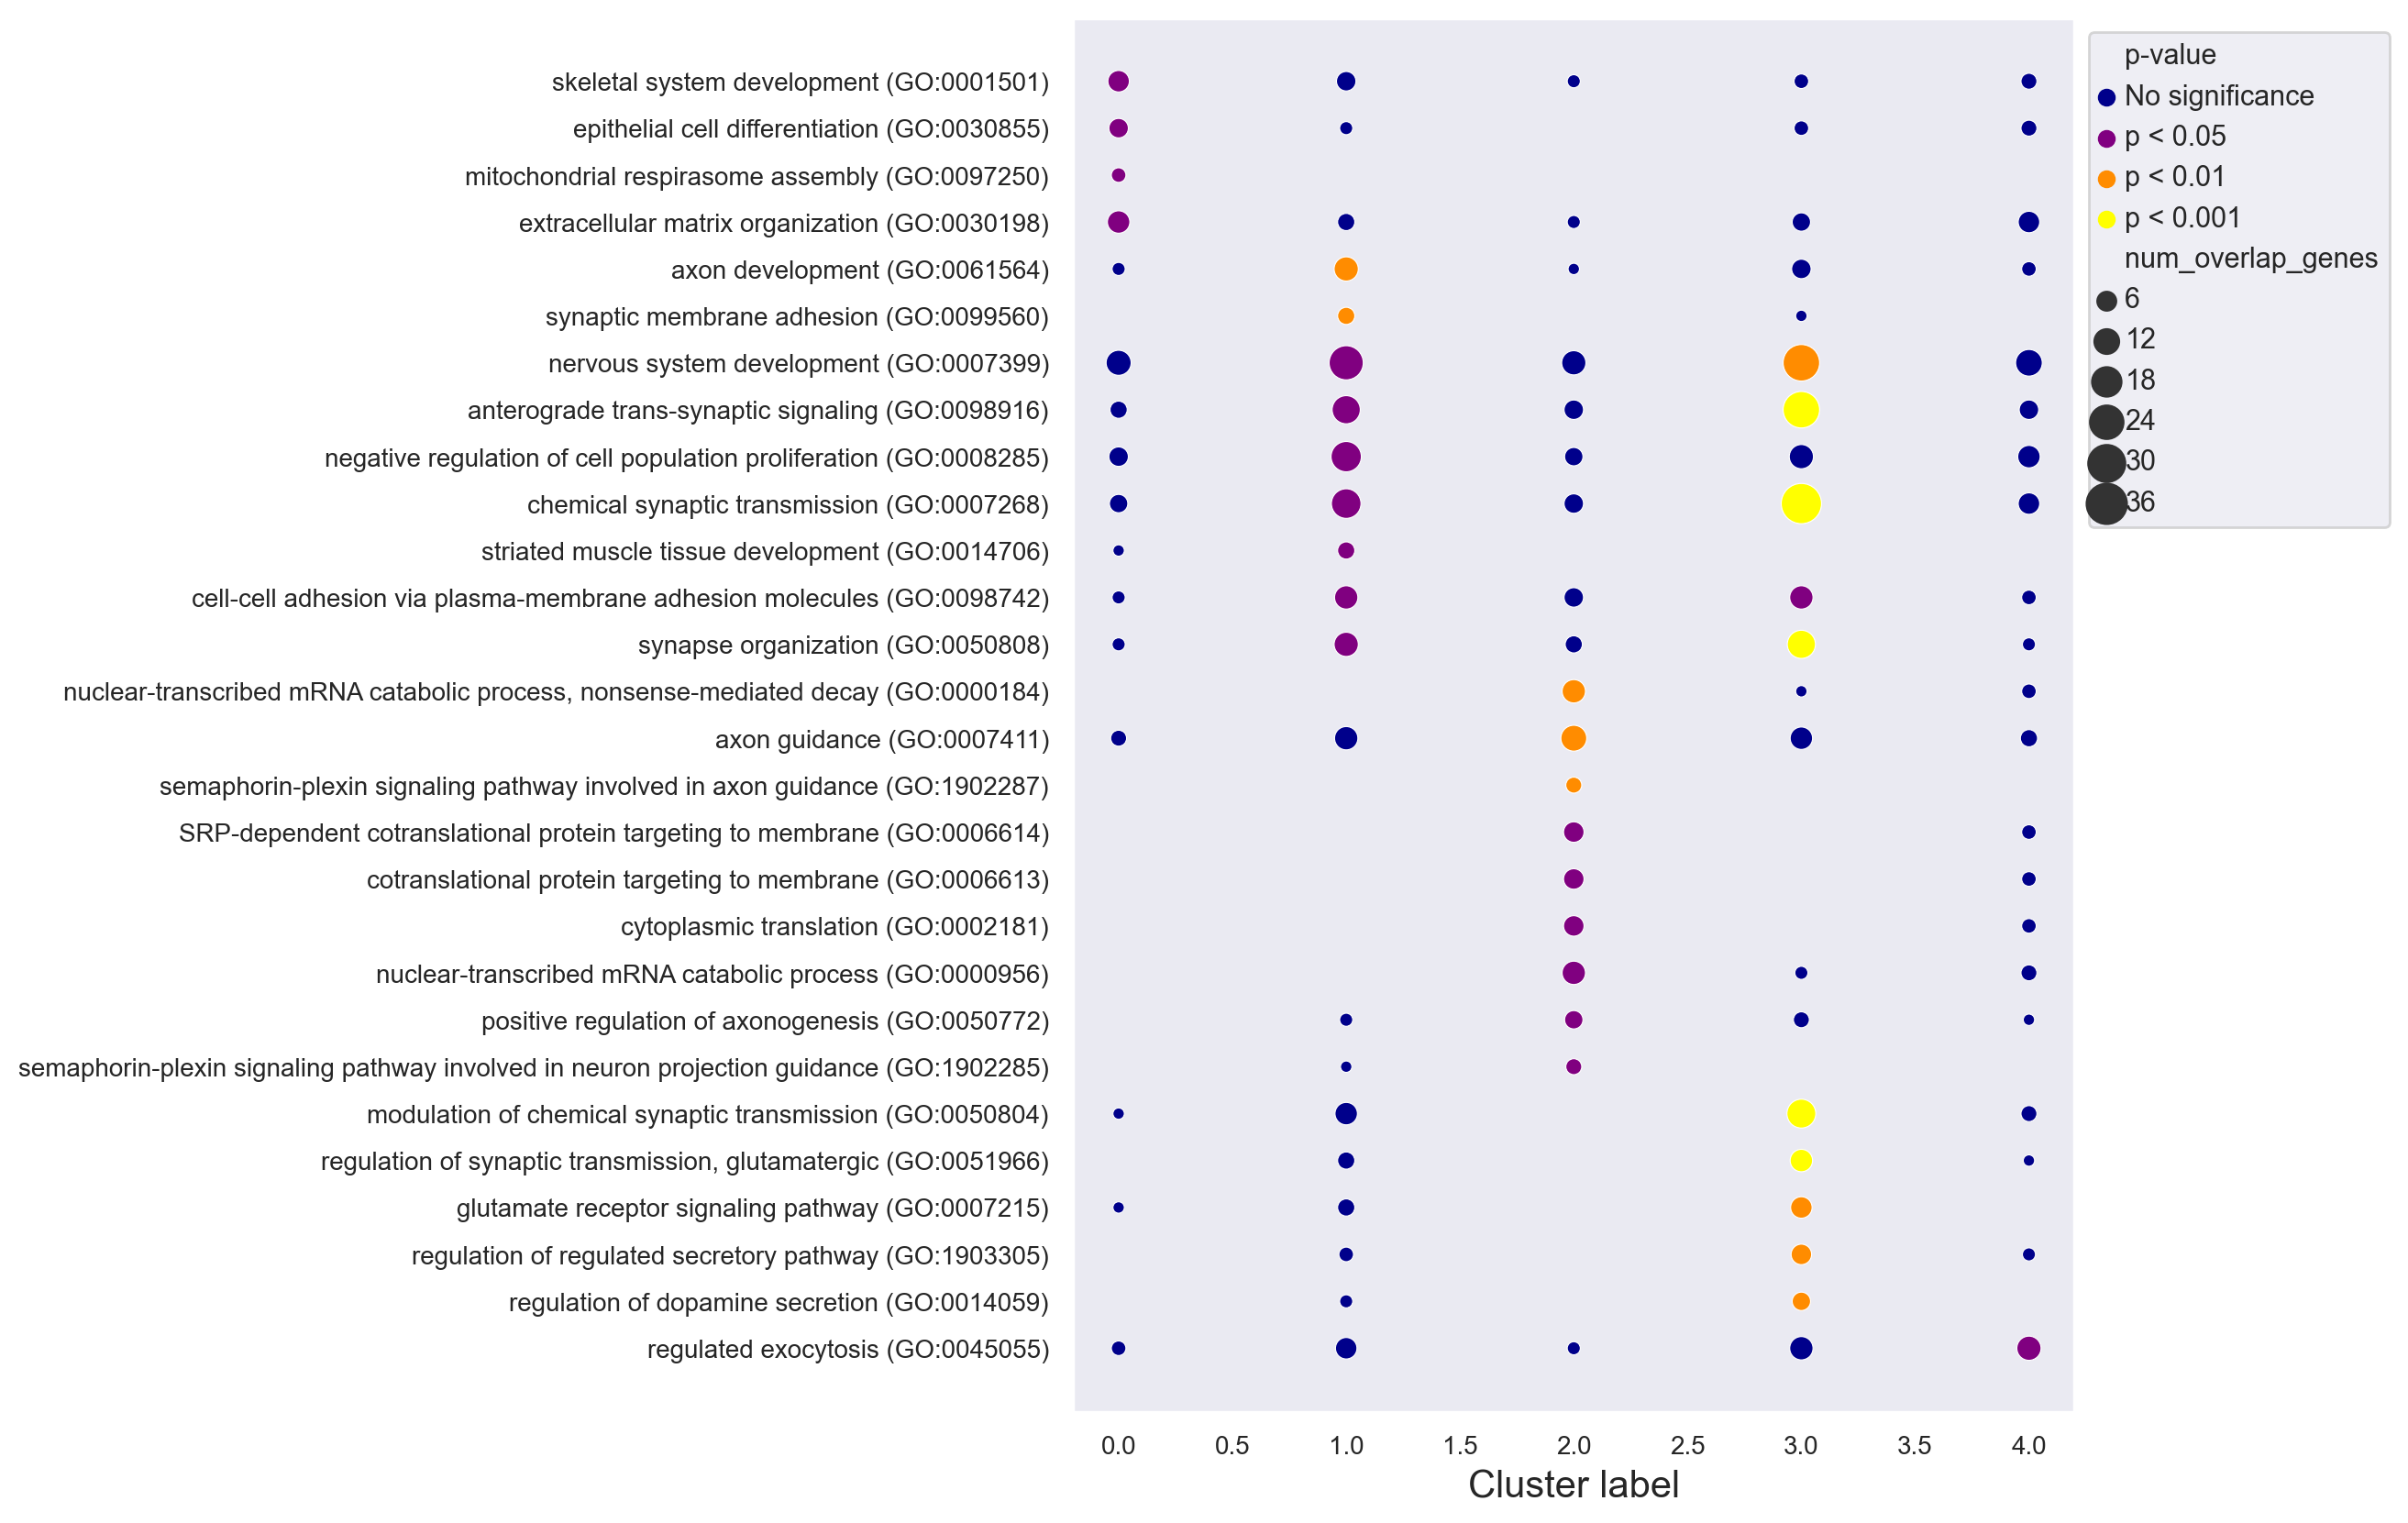

In [35]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [36]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [37]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                            
Airway Smooth Muscle UBERON0004225     1  0.000003  92.865979     1180.707723   
GABAergic Neuron CL0000617             2  0.000014  46.422680      520.286855   
Activated Stellate CL0002410           3  0.000322  34.638462      278.570228   
Pericyte CL0000669                     4  0.001051  19.786813      135.695517   
Myeloid Dendritic Type 1 CL0000782     5  0.002683  45.959184      272.119742   

                                              Overlapping genes  \
Term                                                              
Airway Smooth Muscle UBERON0004225  [ACTA2, TPM2, FLNA, KCNAB1]   
GABAergic Neuron CL0000617            [MAF, GAD1, TCF4, SLC6A1]   
Activated Stellate CL0002410            [COL1A1, COL3A1, SFRP2]   
Pericyte CL0000669                        [PDGFRB, LAMB1, NID1]   
Myeloid Dendritic Type 1 CL0000782                   [GSN, ID2]   

                                    Adjusted P-value  Old p-value  \
Term                                                                
Airway Smooth Muscle UBERON0004225          0.000226            0   
GABAergic Neuron CL0000617                  0.000509            0   
Activated Stellate CL0002410                0.008040            0   
Pericyte CL0000669                          0.019709            0   
Myeloid Dendritic Type 1 CL0000782          0.037490            0   

                                    Old adjusted p-value  num_overlap_genes  \
Term                                                                          
Airway Smooth Muscle UBERON0004225                     0                  4   
GABAergic Neuron CL0000617                             0                  4   
Activated Stellate CL0002410                           0                  3   
Pericyte CL0000669                                     0                  3   
Myeloid Dendritic Type 1 CL0000782                     0                  2   

                                    neg_log10(p_adj)  cluster_label  
Term                                                                 
Airway Smooth Muscle UBERON0004225          3.646604              0  
GABAergic Neuron CL0000617                  3.293368              0  
Activated Stellate CL0002410                2.094753              0  
Pericyte CL0000669                          1.705337              0  
Myeloid Dendritic Type 1 CL0000782          1.426083              0

In [38]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

29

In [39]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

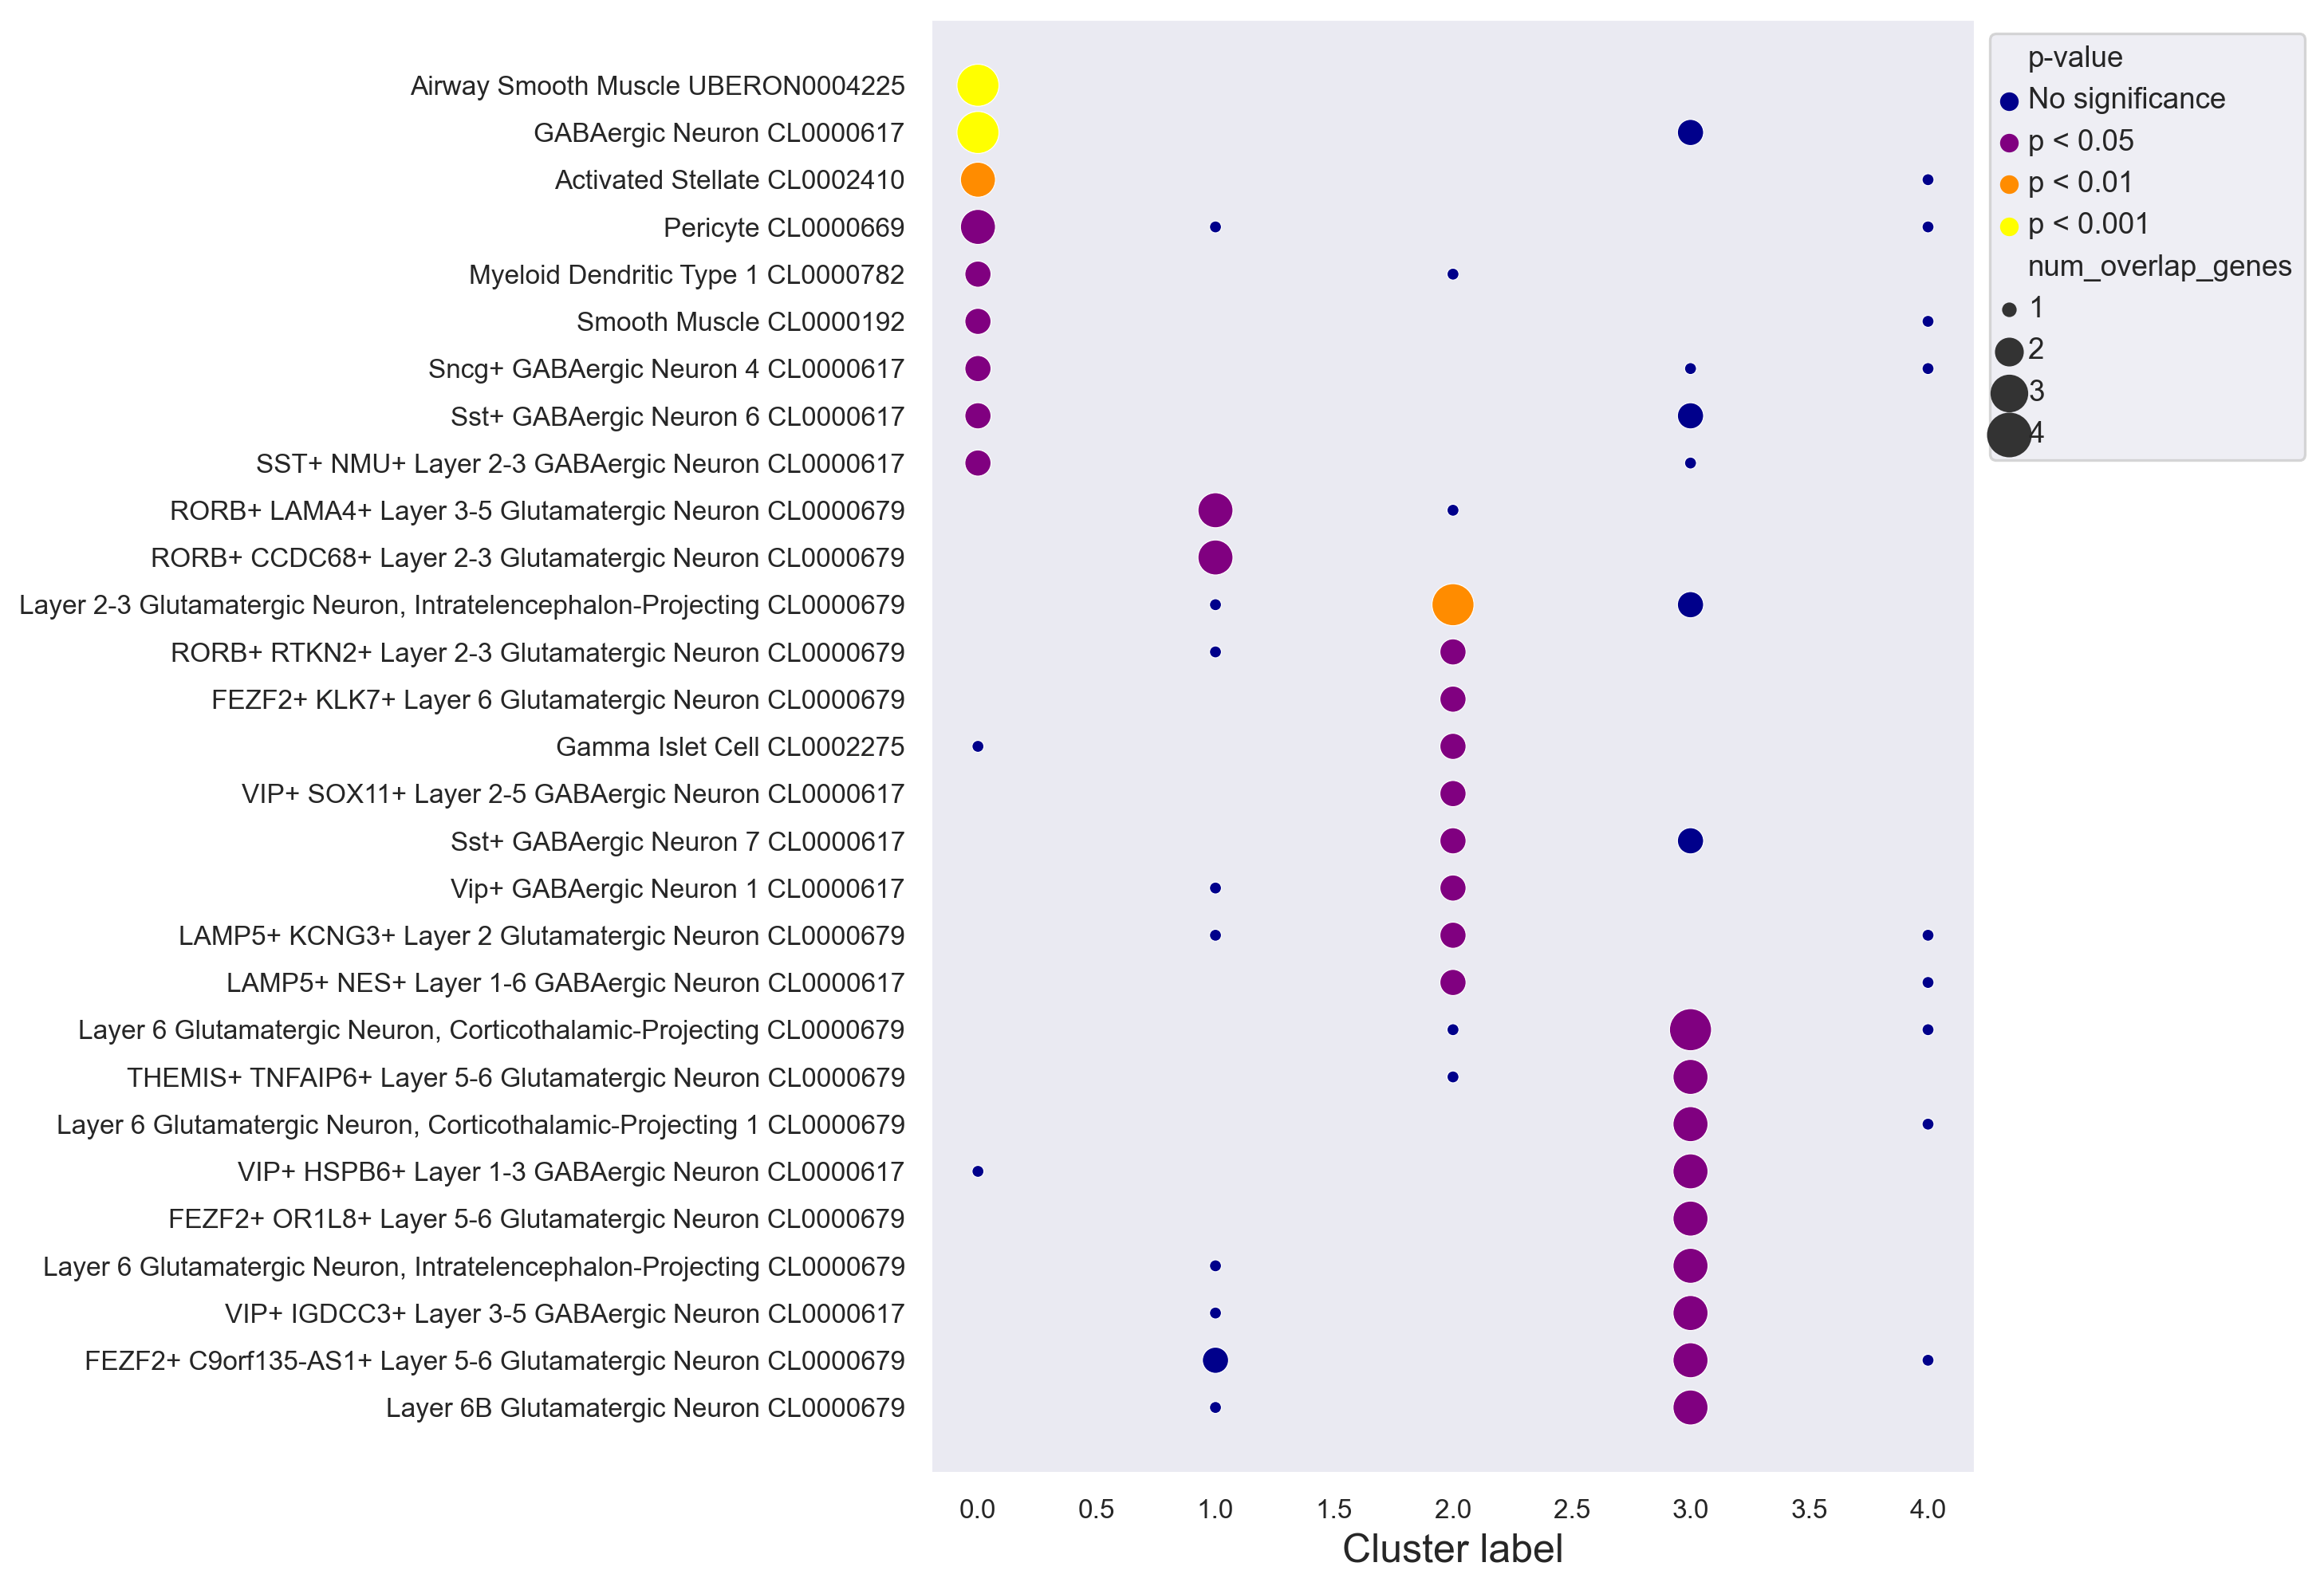

In [40]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [41]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [42]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
impaired cued conditioning behavior MP:0009456         1  0.000099   7.468110   
abnormal aorta elastic tissue morphology MP:000...     2  0.000187  46.189744   
decreased bone mass MP:0004016                         3  0.000235  16.867854   
decreased thermal nociceptive threshold MP:0003998     4  0.000287  10.122775   
abnormal kidney blood vessel morphology MP:0000530     5  0.000322  34.638462   

                                                    Combined score  \
Term                                                                 
impaired cued conditioning behavior MP:0009456           68.838059   
abnormal aorta elastic tissue morphology MP:000...      396.579379   
decreased bone mass MP:0004016                          140.942209   
decreased thermal nociceptive threshold MP:0003998       82.557719   
abnormal kidney blood vessel morphology MP:0000530      278.570228   

                                                                                    Overlapping genes  \
Term                                                                                                    
impaired cued conditioning behavior MP:0009456      [LGALS3, FZD3, ARX, SPARCL1, TCF4, SLC6A1, ARI...   
abnormal aorta elastic tissue morphology MP:000...                            [ACTA2, COL1A1, COL3A1]   
decreased bone mass MP:0004016                                           [COL1A1, RPS6KA3, MGP, FHL2]   
decreased thermal nociceptive threshold MP:0003998            [COL1A1, CNTNAP2, GRIN2A, ARX, CASKIN1]   
abnormal kidney blood vessel morphology MP:0000530                                [PDGFRB, RGS2, MGP]   

                                                    Adjusted P-value  \
Term                                                                   
impaired cued conditioning behavior MP:0009456              0.072772   
abnormal aorta elastic tissue morphology MP:000...          0.072772   
decreased bone mass MP:0004016                              0.072772   
decreased thermal nociceptive threshold MP:0003998          0.072772   
abnormal kidney blood vessel morphology MP:0000530          0.072772   

                                                    Old p-value  \
Term                                                              
impaired cued conditioning behavior MP:0009456                0   
abnormal aorta elastic tissue morphology MP:000...            0   
decreased bone mass MP:0004016                                0   
decreased thermal nociceptive threshold MP:0003998            0   
abnormal kidney blood vessel morphology MP:0000530            0   

                                                    Old adjusted p-value  \
Term                                                                       
impaired cued conditioning behavior MP:0009456                         0   
abnormal aorta elastic tissue morphology MP:000...                     0   
decreased bone mass MP:0004016                                         0   
decreased thermal nociceptive threshold MP:0003998                     0   
abnormal kidney blood vessel morphology MP:0000530                     0   

                                                    num_overlap_genes  \
Term                                                                    
impaired cued conditioning behavior MP:0009456                      7   
abnormal aorta elastic tissue morphology MP:000...                  3   
decreased bone mass MP:0004016                                      4   
decreased thermal nociceptive threshold MP:0003998                  5   
abnormal kidney blood vessel morphology MP:0000530                  3   

                                                    neg_log10(p_adj)  \
Term                                                                   
impaired cued conditioning behavior MP:0009456              1.138036   
abnormal aorta elasti

In [43]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

16

In [44]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

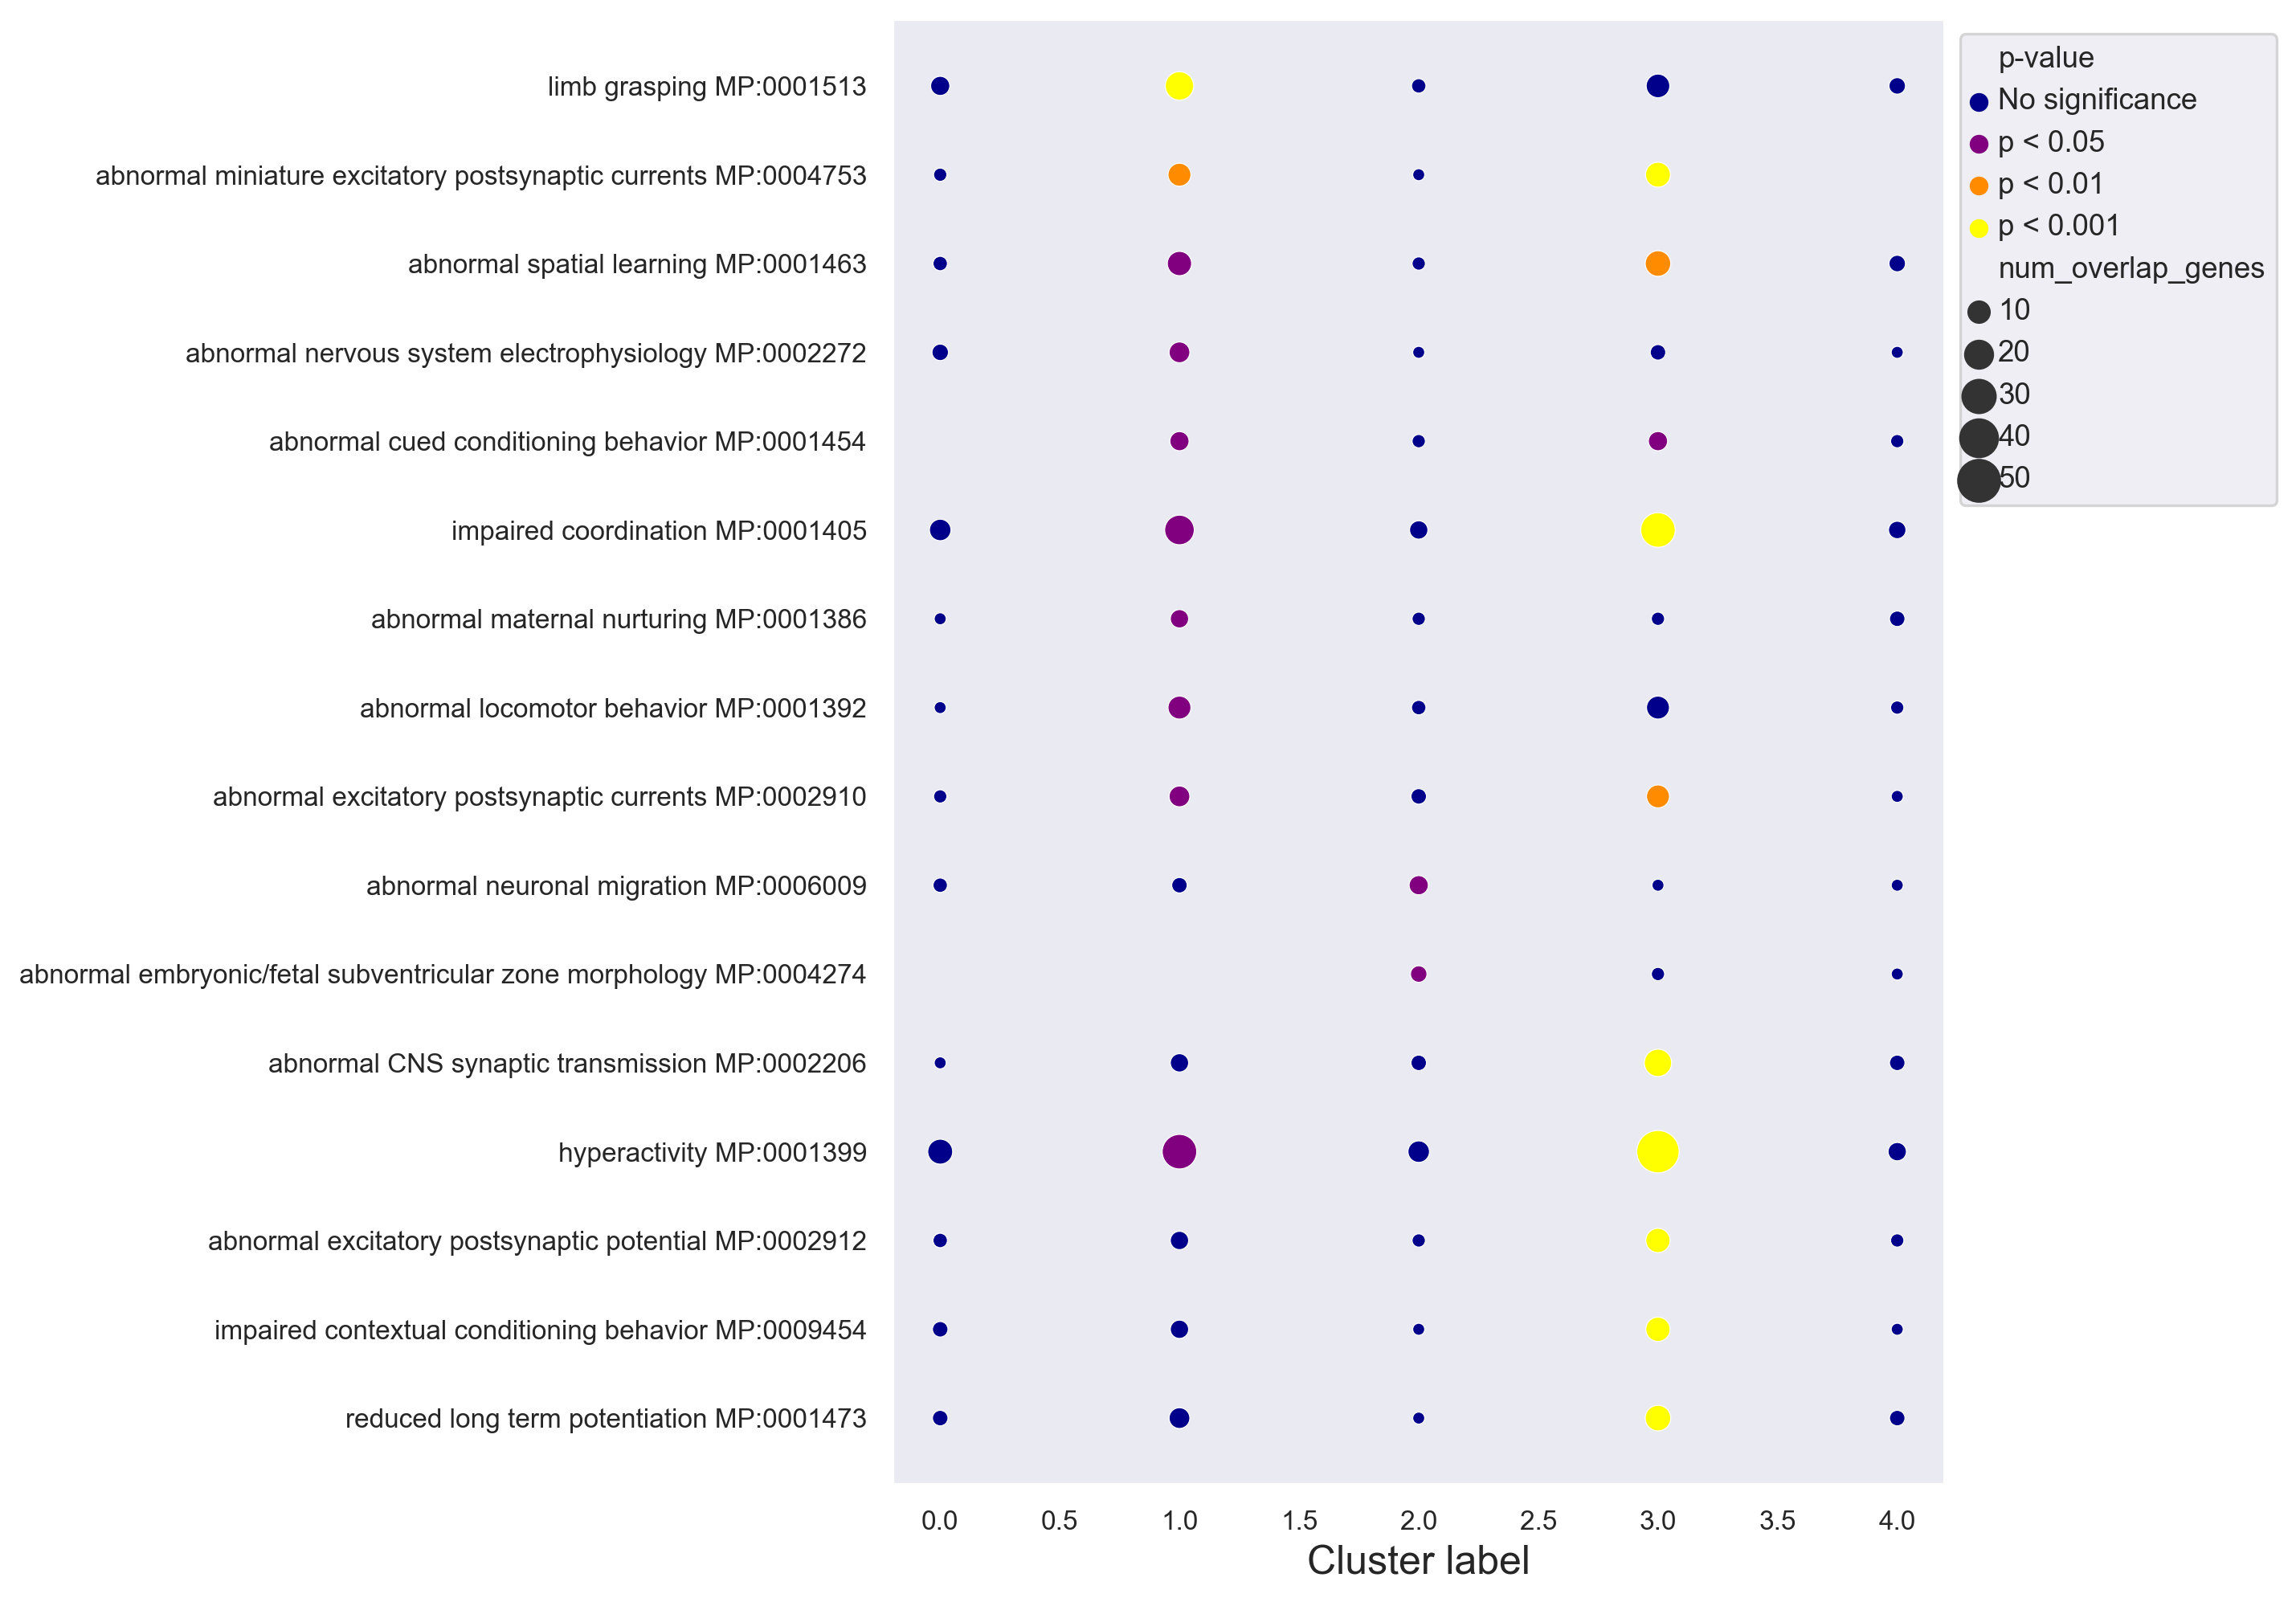

In [45]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [46]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [47]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Collagen Formation R-HSA-1474290                       1  0.000732   8.023048   
Assembly Of Collagen Fibrils And Other Multimer...     2  0.000767  11.590206   
Laminin Interactions R-HSA-3000157                     3  0.001051  19.786813   
Extracellular Matrix Organization R-HSA-1474244        4  0.001162   3.783163   
Collagen Chain Trimerization R-HSA-8948216             5  0.001423  17.311538   

                                                    Combined score  \
Term                                                                 
Collagen Formation R-HSA-1474290                         57.922371   
Assembly Of Collagen Fibrils And Other Multimer...       83.138658   
Laminin Interactions R-HSA-3000157                      135.695517   
Extracellular Matrix Organization R-HSA-1474244          25.565962   
Collagen Chain Trimerization R-HSA-8948216              113.482727   

                                                                                    Overlapping genes  \
Term                                                                                                    
Collagen Formation R-HSA-1474290                            [COL1A1, COL18A1, COL3A1, SERPINH1, PLEC]   
Assembly Of Collagen Fibrils And Other Multimer...                    [COL1A1, COL18A1, COL3A1, PLEC]   
Laminin Interactions R-HSA-3000157                                             [COL18A1, LAMB1, NID1]   
Extracellular Matrix Organization R-HSA-1474244     [COL1A1, COL18A1, COL3A1, SERPINH1, PRKCA, LAM...   
Collagen Chain Trimerization R-HSA-8948216                                  [COL1A1, COL18A1, COL3A1]   

                                                    Adjusted P-value  \
Term                                                                   
Collagen Formation R-HSA-1474290                            0.177172   
Assembly Of Collagen Fibrils And Other Multimer...          0.177172   
Laminin Interactions R-HSA-3000157                          0.177172   
Extracellular Matrix Organization R-HSA-1474244             0.177172   
Collagen Chain Trimerization R-HSA-8948216                  0.177172   

                                                    Old p-value  \
Term                                                              
Collagen Formation R-HSA-1474290                              0   
Assembly Of Collagen Fibrils And Other Multimer...            0   
Laminin Interactions R-HSA-3000157                            0   
Extracellular Matrix Organization R-HSA-1474244               0   
Collagen Chain Trimerization R-HSA-8948216                    0   

                                                    Old adjusted p-value  \
Term                                                                       
Collagen Formation R-HSA-1474290                                       0   
Assembly Of Collagen Fibrils And Other Multimer...                     0   
Laminin Interactions R-HSA-3000157                                     0   
Extracellular Matrix Organization R-HSA-1474244                        0   
Collagen Chain Trimerization R-HSA-8948216                             0   

                                                    num_overlap_genes  \
Term                                                                    
Collagen Formation R-HSA-1474290                                    5   
Assembly Of Collagen Fibrils And Other Multimer...                  4   
Laminin Interactions R-HSA-3000157                                  3   
Extracellular Matrix Organization R-HSA-1474244                     9   
Collagen Chain Trimerization R-HSA-8948216                          3   

                                                    neg_log10(p_adj)  \
Term                                                                   
Collagen Formation R-HSA-1474290                            0.751604   
Assembly Of Collagen 

In [48]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

22

In [49]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

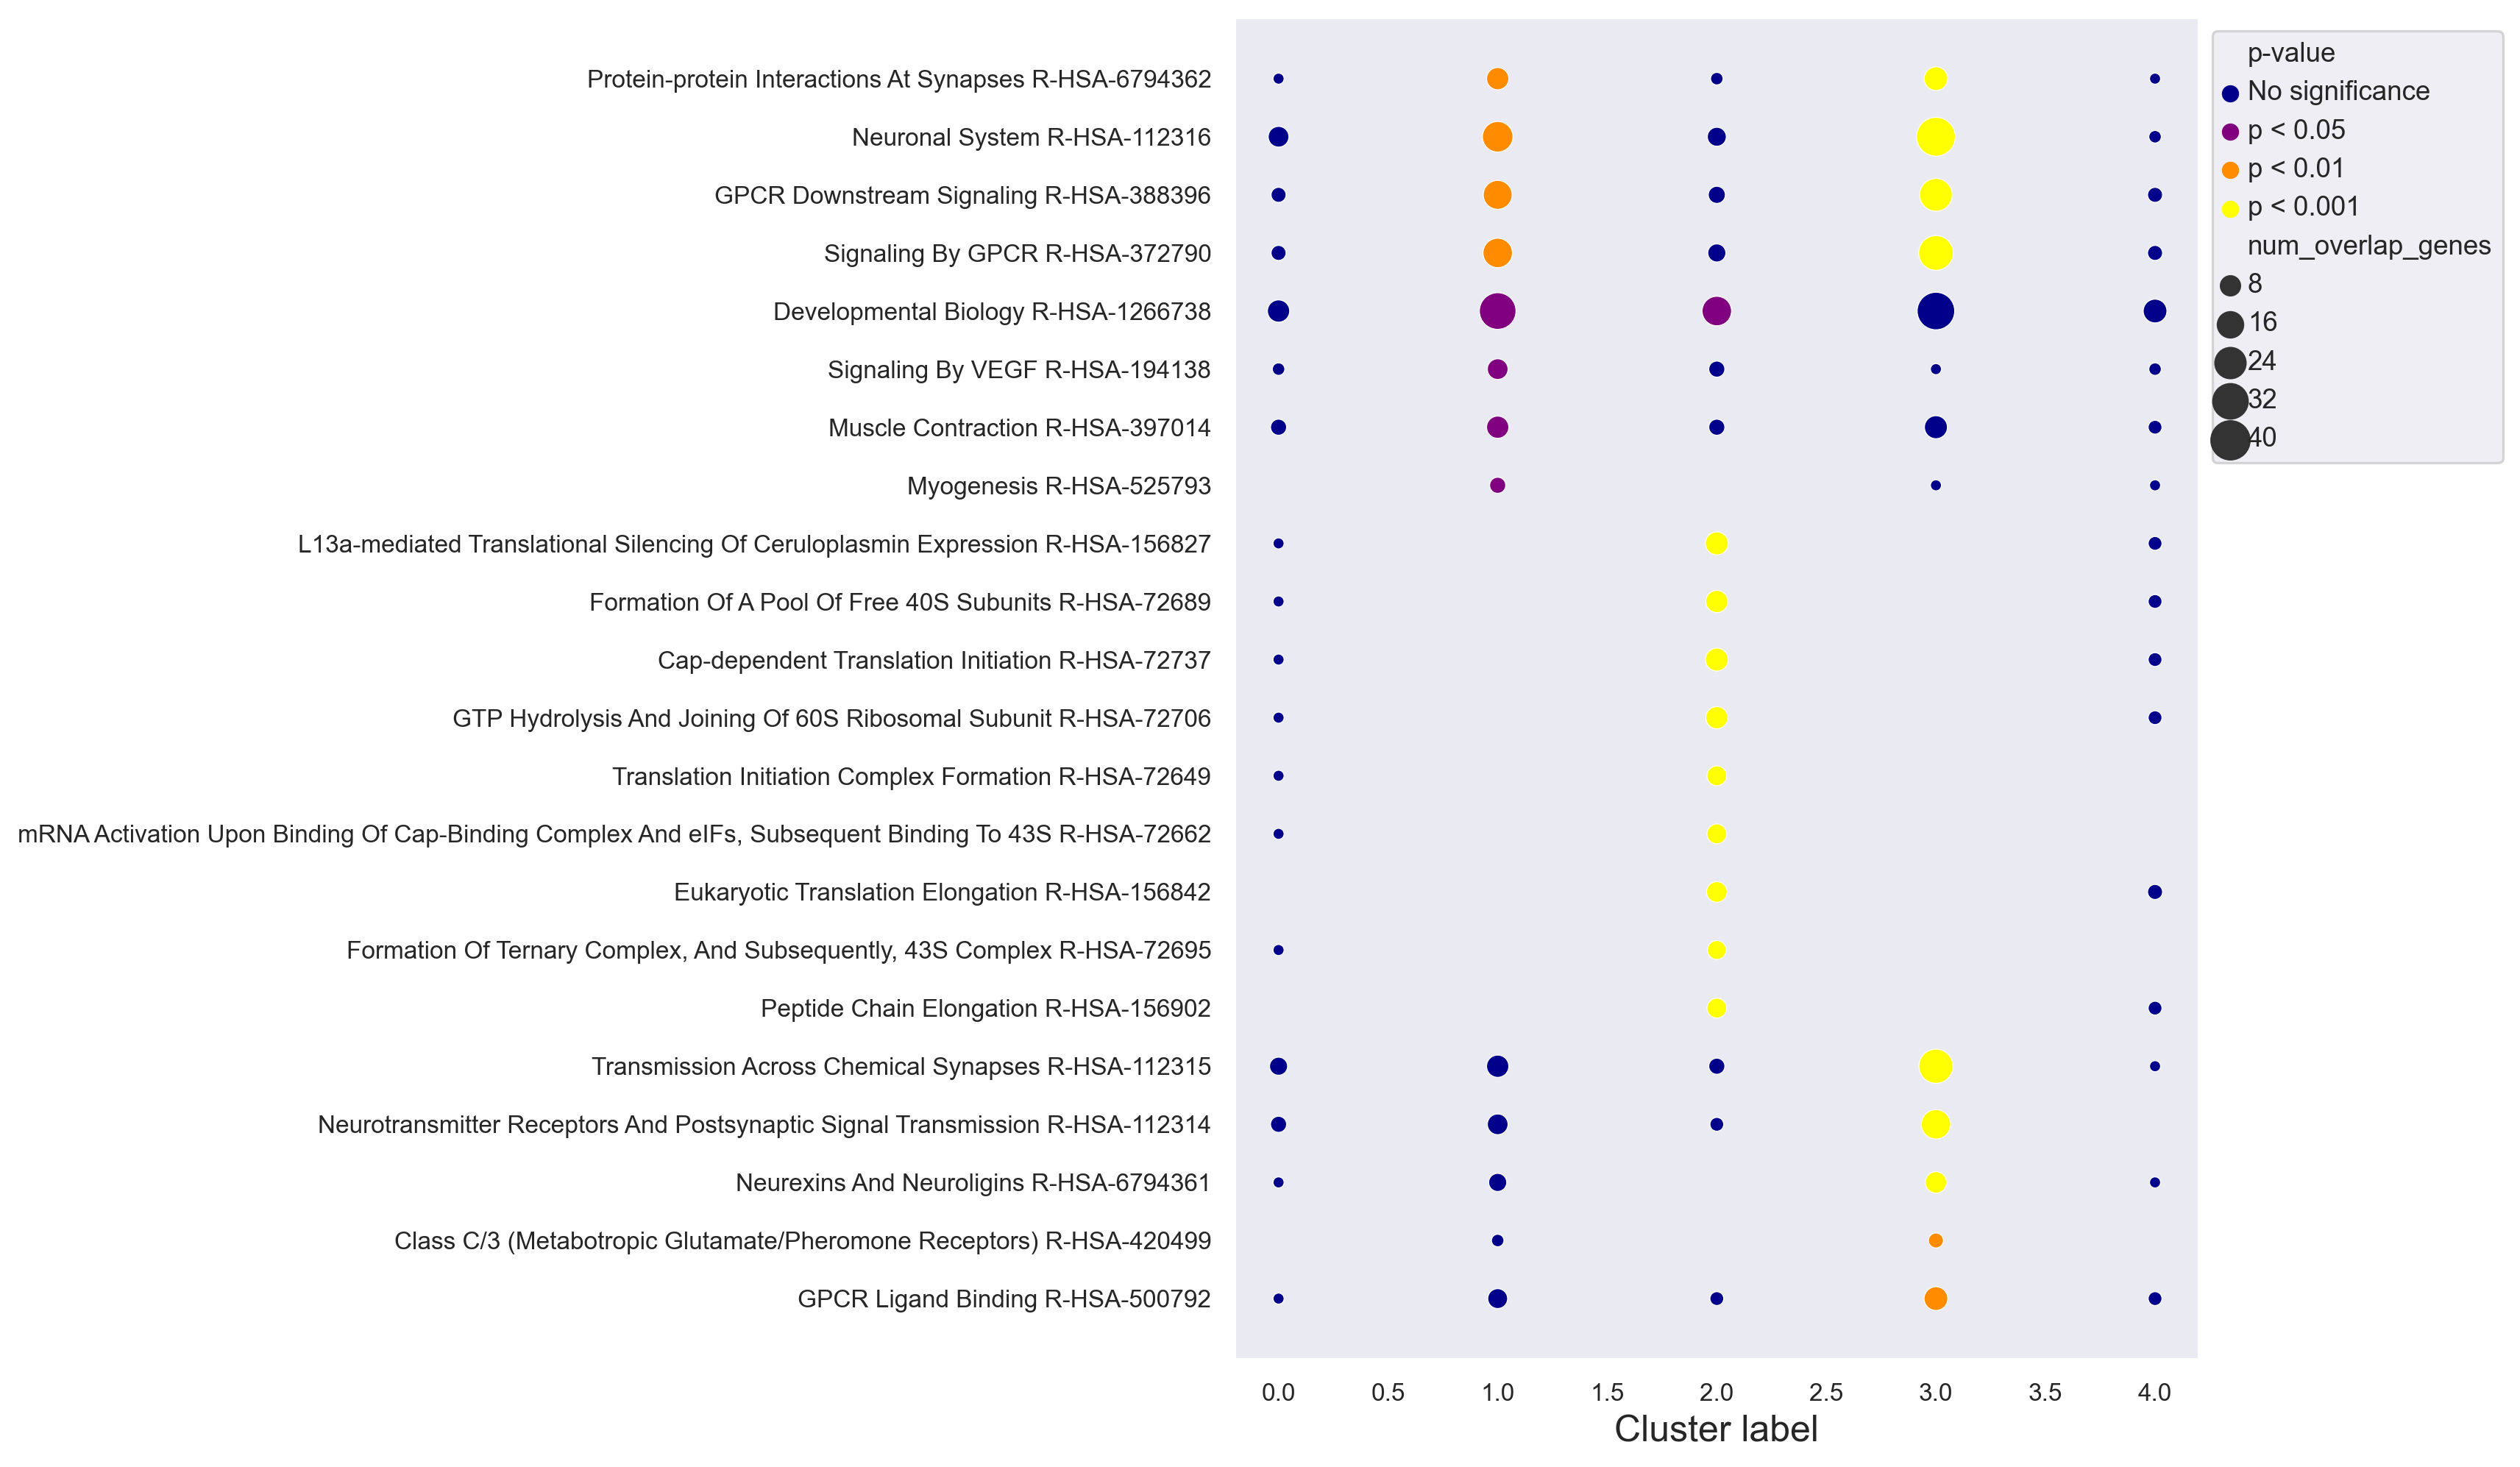

In [50]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [51]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [52]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val   Z-score  Combined score  \
Term                                                                  
Diabetic cardiomyopathy       1  0.000683  3.750422       27.339473   
Oxidative phosphorylation     2  0.001861  4.366143       27.447483   
Thermogenesis                 3  0.006194  2.891063       14.698763   
Amoebiasis                    4  0.015540  4.510435       18.782962   
Proteoglycans in cancer       5  0.016036  2.834737       11.715674   

                                                           Overlapping genes  \
Term                                                                           
Diabetic cardiomyopathy    [COL1A1, COX8A, NDUFA8, COL3A1, NDUFB4, PRKCA,...   
Oxidative phosphorylation  [COX8A, NDUFA8, ATP6V1G1, NDUFB4, COX7A2, NDUF...   
Thermogenesis              [COX8A, SMARCD1, NDUFA8, RPS6KA3, NDUFB4, COX7...   
Amoebiasis                                    [COL1A1, COL3A1, PRKCA, LAMB1]   
Proteoglycans in cancer       [COL1A1, FZD3, ERBB4, FLNA, RRAS2, PRKCA, DCN]   

                           Adjusted P-value  Old p-value  \
Term                                                       
Diabetic cardiomyopathy            0.126950            0   
Oxidative phosphorylation          0.173108            0   
Thermogenesis                      0.384016            0   
Amoebiasis                         0.429962            0   
Proteoglycans in cancer            0.429962            0   

                           Old adjusted p-value  num_overlap_genes  \
Term                                                                 
Diabetic cardiomyopathy                       0                 10   
Oxidative phosphorylation                     0                  7   
Thermogenesis                                 0                  9   
Amoebiasis                                    0                  4   
Proteoglycans in cancer                       0                  7   

                           neg_log10(p_adj)  cluster_label  
Term                                                        
Diabetic cardiomyopathy            0.896366              0  
Oxidative phosphorylation          0.761682              0  
Thermogenesis                      0.415651              0  
Amoebiasis                         0.366570              0  
Proteoglycans in cancer            0.366570              0

In [53]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

17

In [54]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

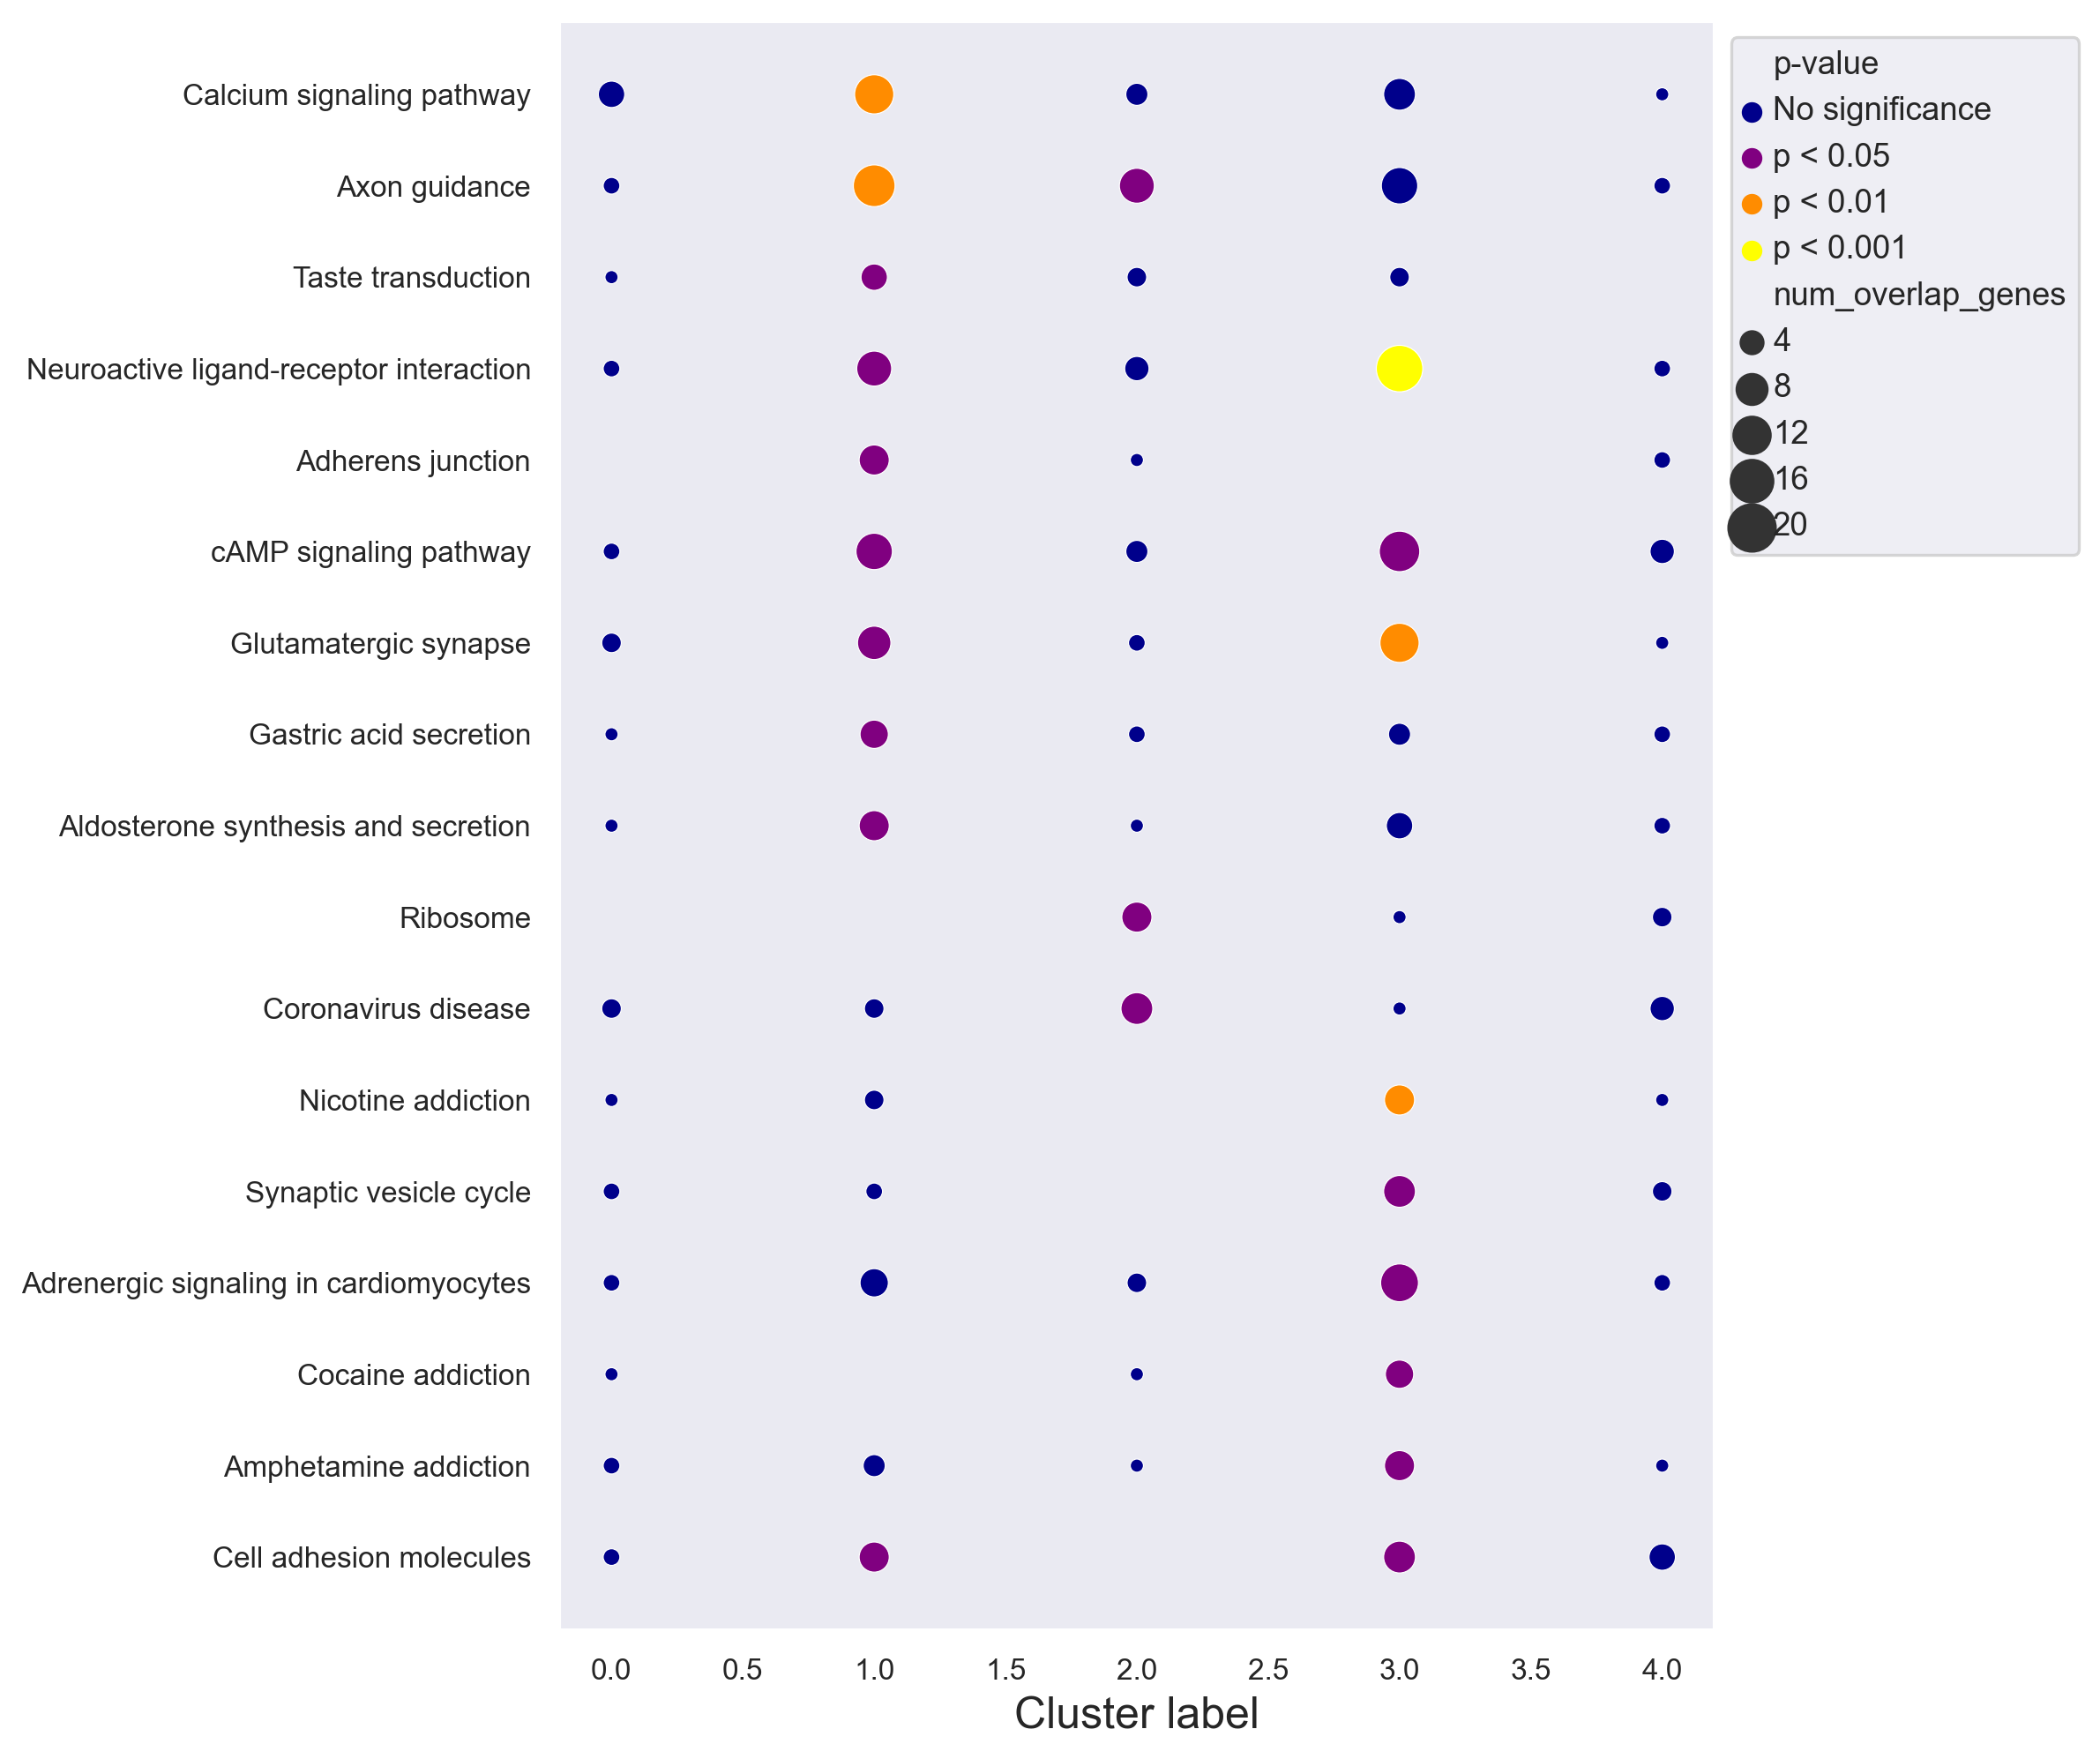

In [55]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))